# Import Libraries

In [ ]:
#https://github.com/tanishqgautam/Drone-Image-Semantic-Segmentation/blob/main/semantic-segmentation-pytorch.ipynb
#https://towardsdatascience.com/the-essential-library-to-build-segmentation-models-6e17e81338e

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install segmentation-models-pytorch #installam bibliotecile pe colab
!pip install -U albumentations

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install segmentation-models-pytorch
!pip install torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=12f518dd68e190fa178e1321414926c9dc5933148e1acab1c59ab06e994e1bf5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=c8b5efc169b12357b3bba373fa6d372bf5ce823222988dbf1855c60255674f0c
  Stored in di

In [2]:
os.chdir('/content/gdrive/MyDrive/date_dizertatie')
base_path = '/content/gdrive/MyDrive/date_dizertatie'

# Preprocessing

In [3]:
# IMAGE_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
# MASK_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

IMAGE_PATH = base_path + '/graz_drone_dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = base_path + '/graz_drone_dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [4]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [5]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


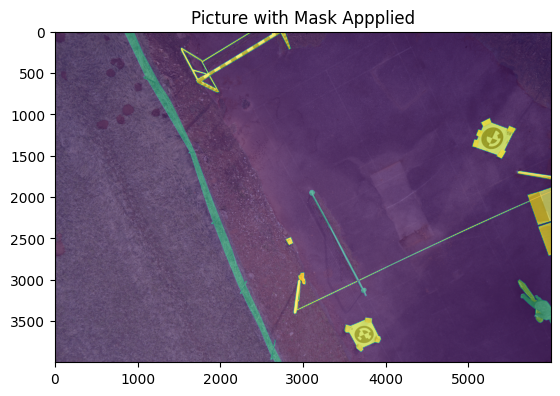

In [12]:
img = Image.open(IMAGE_PATH + df['id'][224] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][224] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

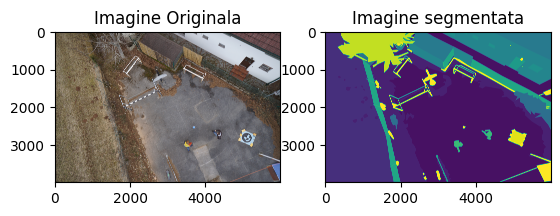

<Figure size 640x480 with 0 Axes>

# Dataset

In [102]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        originala = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        originala = cv2.cvtColor(originala, cv2.COLOR_BGR2RGB)

        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask, originala
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [103]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

**bold text**# Model\

---



In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context #bug ssl

unet_mobile = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
unet_resnet = smp.Unet('resnet34', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
unet_efficient = smp.Unet('efficientnet-b0', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
unet_densenet = smp.Unet('densenet121', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [ ]:
#model

# Training

*   List item
*   List item



In [58]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [57]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

#unet_mobile
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(unet_mobile.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history_mobile = fit(epoch, unet_mobile, train_loader, val_loader, criterion, optimizer, sched)
torch.save(unet_resnet, 'unet-mobilenet.pt')
column = list(history_mobile.keys())[:-1]
val = list(history_mobile.values())[:-1]
test = dict(zip(column, val))
df = pd.DataFrame.from_dict(test, orient='index')
nn_crs = df.transpose()
nn_crs.to_csv('unet_mobilenet_cross_entropy.csv')



  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.274 
Epoch:1/15.. Train Loss: 2.891.. Val Loss: 2.274.. Train mIoU:0.059.. Val mIoU: 0.122.. Train Acc:0.269.. Val Acc:0.554.. Time: 19.53m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.274 >> 1.550 
Epoch:2/15.. Train Loss: 1.912.. Val Loss: 1.550.. Train mIoU:0.126.. Val mIoU: 0.141.. Train Acc:0.577.. Val Acc:0.636.. Time: 4.70m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.550 >> 1.176 
Epoch:3/15.. Train Loss: 1.398.. Val Loss: 1.176.. Train mIoU:0.150.. Val mIoU: 0.166.. Train Acc:0.618.. Val Acc:0.688.. Time: 4.74m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.176 >> 1.112 
saving model...
Epoch:4/15.. Train Loss: 1.257.. Val Loss: 1.112.. Train mIoU:0.166.. Val mIoU: 0.188.. Train Acc:0.643.. Val Acc:0.694.. Time: 4.73m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.112 >> 0.938 
Epoch:5/15.. Train Loss: 1.154.. Val Loss: 0.938.. Train mIoU:0.185.. Val mIoU: 0.201.. Train Acc:0.668.. Val Acc:0.732.. Time: 4.82m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:6/15.. Train Loss: 1.082.. Val Loss: 0.952.. Train mIoU:0.206.. Val mIoU: 0.208.. Train Acc:0.681.. Val Acc:0.721.. Time: 4.74m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.952 >> 0.886 
Epoch:7/15.. Train Loss: 1.049.. Val Loss: 0.886.. Train mIoU:0.215.. Val mIoU: 0.220.. Train Acc:0.696.. Val Acc:0.735.. Time: 4.77m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.886 >> 0.830 
Epoch:8/15.. Train Loss: 0.999.. Val Loss: 0.830.. Train mIoU:0.224.. Val mIoU: 0.229.. Train Acc:0.712.. Val Acc:0.753.. Time: 4.72m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:9/15.. Train Loss: 0.909.. Val Loss: 0.846.. Train mIoU:0.238.. Val mIoU: 0.232.. Train Acc:0.733.. Val Acc:0.739.. Time: 4.82m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.846 >> 0.723 
Epoch:10/15.. Train Loss: 0.834.. Val Loss: 0.723.. Train mIoU:0.257.. Val mIoU: 0.233.. Train Acc:0.756.. Val Acc:0.770.. Time: 4.74m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:11/15.. Train Loss: 0.787.. Val Loss: 0.745.. Train mIoU:0.268.. Val mIoU: 0.247.. Train Acc:0.769.. Val Acc:0.761.. Time: 4.75m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.745 >> 0.656 
saving model...
Epoch:12/15.. Train Loss: 0.717.. Val Loss: 0.656.. Train mIoU:0.291.. Val mIoU: 0.283.. Train Acc:0.791.. Val Acc:0.799.. Time: 4.68m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.656 >> 0.621 
Epoch:13/15.. Train Loss: 0.670.. Val Loss: 0.621.. Train mIoU:0.307.. Val mIoU: 0.304.. Train Acc:0.806.. Val Acc:0.815.. Time: 4.72m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.621 >> 0.611 
Epoch:14/15.. Train Loss: 0.657.. Val Loss: 0.611.. Train mIoU:0.317.. Val mIoU: 0.311.. Train Acc:0.809.. Val Acc:0.813.. Time: 4.73m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:15/15.. Train Loss: 0.646.. Val Loss: 0.621.. Train mIoU:0.317.. Val mIoU: 0.308.. Train Acc:0.813.. Val Acc:0.813.. Time: 4.72m
Total time: 85.92 m


In [ ]:
#unet_resnet
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(unet_resnet.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history_resnet = fit(epoch, unet_resnet, train_loader, val_loader, criterion, optimizer, sched)
torch.save(unet_resnet, 'unet-resnet.pt')
column = list(history_resnet.keys())[:-1]
val = list(history_resnet.values())[:-1]
test = dict(zip(column, val))
df = pd.DataFrame.from_dict(test, orient='index')
nn_crs = df.transpose()
nn_crs.to_csv('unet_resnet_cross_entropy.csv')

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.805 
Epoch:1/15.. Train Loss: 2.615.. Val Loss: 1.805.. Train mIoU:0.054.. Val mIoU: 0.112.. Train Acc:0.301.. Val Acc:0.562.. Time: 4.94m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.805 >> 1.517 
Epoch:2/15.. Train Loss: 1.737.. Val Loss: 1.517.. Train mIoU:0.121.. Val mIoU: 0.133.. Train Acc:0.580.. Val Acc:0.641.. Time: 4.96m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/15.. Train Loss: 1.511.. Val Loss: 1.946.. Train mIoU:0.120.. Val mIoU: 0.070.. Train Acc:0.578.. Val Acc:0.456.. Time: 4.94m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.946 >> 1.329 
Epoch:4/15.. Train Loss: 1.501.. Val Loss: 1.329.. Train mIoU:0.117.. Val mIoU: 0.122.. Train Acc:0.553.. Val Acc:0.603.. Time: 4.90m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.329 >> 1.319 
saving model...
Epoch:5/15.. Train Loss: 1.360.. Val Loss: 1.319.. Train mIoU:0.132.. Val mIoU: 0.130.. Train Acc:0.599.. Val Acc:0.623.. Time: 4.95m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/15.. Train Loss: 1.267.. Val Loss: 1.393.. Train mIoU:0.147.. Val mIoU: 0.132.. Train Acc:0.625.. Val Acc:0.630.. Time: 4.93m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.393 >> 1.105 
Epoch:7/15.. Train Loss: 1.269.. Val Loss: 1.105.. Train mIoU:0.149.. Val mIoU: 0.165.. Train Acc:0.623.. Val Acc:0.680.. Time: 4.94m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.105 >> 0.961 
Epoch:8/15.. Train Loss: 1.122.. Val Loss: 0.961.. Train mIoU:0.175.. Val mIoU: 0.186.. Train Acc:0.670.. Val Acc:0.722.. Time: 4.91m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.961 >> 0.907 
Epoch:9/15.. Train Loss: 1.041.. Val Loss: 0.907.. Train mIoU:0.187.. Val mIoU: 0.201.. Train Acc:0.690.. Val Acc:0.732.. Time: 4.93m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:10/15.. Train Loss: 1.015.. Val Loss: 0.954.. Train mIoU:0.202.. Val mIoU: 0.208.. Train Acc:0.698.. Val Acc:0.717.. Time: 4.92m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.954 >> 0.832 
Epoch:11/15.. Train Loss: 0.961.. Val Loss: 0.832.. Train mIoU:0.211.. Val mIoU: 0.214.. Train Acc:0.715.. Val Acc:0.748.. Time: 4.92m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.832 >> 0.808 
saving model...
Epoch:12/15.. Train Loss: 0.845.. Val Loss: 0.808.. Train mIoU:0.238.. Val mIoU: 0.242.. Train Acc:0.749.. Val Acc:0.758.. Time: 4.99m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.808 >> 0.732 
Epoch:13/15.. Train Loss: 0.823.. Val Loss: 0.732.. Train mIoU:0.240.. Val mIoU: 0.253.. Train Acc:0.756.. Val Acc:0.778.. Time: 4.94m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.732 >> 0.703 
Epoch:14/15.. Train Loss: 0.757.. Val Loss: 0.703.. Train mIoU:0.260.. Val mIoU: 0.272.. Train Acc:0.776.. Val Acc:0.793.. Time: 4.93m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.703 >> 0.701 
Epoch:15/15.. Train Loss: 0.766.. Val Loss: 0.701.. Train mIoU:0.257.. Val mIoU: 0.259.. Train Acc:0.774.. Val Acc:0.794.. Time: 4.89m
Total time: 74.00 m


In [ ]:
#unet_efficient
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(unet_efficient.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history_efficient = fit(epoch, unet_efficient, train_loader, val_loader, criterion, optimizer, sched)
torch.save(unet_efficient, 'unet-efficient.pt')
column = list(history_efficient.keys())[:-1]
val = list(history_efficient.values())[:-1]
test = dict(zip(column, val))
df = pd.DataFrame.from_dict(test, orient='index')
nn_crs = df.transpose()
nn_crs.to_csv('unet_efficient_cross_entropy.csv')

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.411 
Epoch:1/15.. Train Loss: 2.890.. Val Loss: 2.411.. Train mIoU:0.029.. Val mIoU: 0.061.. Train Acc:0.181.. Val Acc:0.419.. Time: 4.92m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.411 >> 1.326 
Epoch:2/15.. Train Loss: 1.887.. Val Loss: 1.326.. Train mIoU:0.089.. Val mIoU: 0.124.. Train Acc:0.540.. Val Acc:0.670.. Time: 4.91m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.326 >> 1.072 
Epoch:3/15.. Train Loss: 1.356.. Val Loss: 1.072.. Train mIoU:0.129.. Val mIoU: 0.145.. Train Acc:0.631.. Val Acc:0.706.. Time: 4.76m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.072 >> 1.029 
saving model...
Epoch:4/15.. Train Loss: 1.171.. Val Loss: 1.029.. Train mIoU:0.155.. Val mIoU: 0.162.. Train Acc:0.669.. Val Acc:0.713.. Time: 4.74m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.029 >> 0.972 
Epoch:5/15.. Train Loss: 1.117.. Val Loss: 0.972.. Train mIoU:0.166.. Val mIoU: 0.183.. Train Acc:0.677.. Val Acc:0.724.. Time: 4.76m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.972 >> 0.875 
Epoch:6/15.. Train Loss: 0.986.. Val Loss: 0.875.. Train mIoU:0.196.. Val mIoU: 0.203.. Train Acc:0.717.. Val Acc:0.743.. Time: 4.72m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:7/15.. Train Loss: 0.940.. Val Loss: 0.911.. Train mIoU:0.213.. Val mIoU: 0.215.. Train Acc:0.724.. Val Acc:0.732.. Time: 4.77m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.911 >> 0.793 
Epoch:8/15.. Train Loss: 0.891.. Val Loss: 0.793.. Train mIoU:0.224.. Val mIoU: 0.242.. Train Acc:0.737.. Val Acc:0.764.. Time: 4.69m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.793 >> 0.664 
Epoch:9/15.. Train Loss: 0.783.. Val Loss: 0.664.. Train mIoU:0.260.. Val mIoU: 0.288.. Train Acc:0.773.. Val Acc:0.807.. Time: 4.72m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.664 >> 0.631 
saving model...
Epoch:10/15.. Train Loss: 0.739.. Val Loss: 0.631.. Train mIoU:0.272.. Val mIoU: 0.285.. Train Acc:0.784.. Val Acc:0.812.. Time: 4.71m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.631 >> 0.586 
Epoch:11/15.. Train Loss: 0.677.. Val Loss: 0.586.. Train mIoU:0.287.. Val mIoU: 0.291.. Train Acc:0.799.. Val Acc:0.818.. Time: 4.70m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.586 >> 0.560 
Epoch:12/15.. Train Loss: 0.628.. Val Loss: 0.560.. Train mIoU:0.306.. Val mIoU: 0.312.. Train Acc:0.814.. Val Acc:0.831.. Time: 4.64m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.560 >> 0.553 
Epoch:13/15.. Train Loss: 0.640.. Val Loss: 0.553.. Train mIoU:0.309.. Val mIoU: 0.323.. Train Acc:0.815.. Val Acc:0.835.. Time: 4.63m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.553 >> 0.543 
Epoch:14/15.. Train Loss: 0.603.. Val Loss: 0.543.. Train mIoU:0.320.. Val mIoU: 0.318.. Train Acc:0.820.. Val Acc:0.836.. Time: 4.63m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:15/15.. Train Loss: 0.594.. Val Loss: 0.543.. Train mIoU:0.318.. Val mIoU: 0.317.. Train Acc:0.826.. Val Acc:0.836.. Time: 4.67m
Total time: 70.97 m


In [ ]:
#unet_densenet
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(unet_densenet.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history_densenet = fit(epoch, unet_densenet, train_loader, val_loader, criterion, optimizer, sched)
torch.save(unet_efficient, 'unet-densenet.pt')
column = list(history_densenet.keys())[:-1]
val = list(history_densenet.values())[:-1]
test = dict(zip(column, val))
df = pd.DataFrame.from_dict(test, orient='index')
nn_crs = df.transpose()
nn_crs.to_csv('unet_densenet_cross_entropy.csv')

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.779 
Epoch:1/15.. Train Loss: 2.612.. Val Loss: 1.779.. Train mIoU:0.070.. Val mIoU: 0.141.. Train Acc:0.331.. Val Acc:0.655.. Time: 5.17m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.779 >> 1.544 
Epoch:2/15.. Train Loss: 1.689.. Val Loss: 1.544.. Train mIoU:0.137.. Val mIoU: 0.129.. Train Acc:0.615.. Val Acc:0.634.. Time: 5.11m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.544 >> 1.411 
Epoch:3/15.. Train Loss: 1.370.. Val Loss: 1.411.. Train mIoU:0.145.. Val mIoU: 0.120.. Train Acc:0.627.. Val Acc:0.596.. Time: 5.15m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/15.. Train Loss: 1.293.. Val Loss: 1.598.. Train mIoU:0.149.. Val mIoU: 0.149.. Train Acc:0.632.. Val Acc:0.586.. Time: 5.13m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.598 >> 1.032 
saving model...
Epoch:5/15.. Train Loss: 1.159.. Val Loss: 1.032.. Train mIoU:0.172.. Val mIoU: 0.182.. Train Acc:0.660.. Val Acc:0.710.. Time: 5.16m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.032 >> 1.019 
Epoch:6/15.. Train Loss: 1.169.. Val Loss: 1.019.. Train mIoU:0.181.. Val mIoU: 0.188.. Train Acc:0.653.. Val Acc:0.708.. Time: 5.17m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.019 >> 1.016 
Epoch:7/15.. Train Loss: 1.042.. Val Loss: 1.016.. Train mIoU:0.197.. Val mIoU: 0.200.. Train Acc:0.689.. Val Acc:0.705.. Time: 5.18m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/15.. Train Loss: 1.007.. Val Loss: 1.040.. Train mIoU:0.215.. Val mIoU: 0.204.. Train Acc:0.702.. Val Acc:0.677.. Time: 5.13m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.040 >> 0.809 
Epoch:9/15.. Train Loss: 0.918.. Val Loss: 0.809.. Train mIoU:0.233.. Val mIoU: 0.233.. Train Acc:0.730.. Val Acc:0.752.. Time: 5.14m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.809 >> 0.710 
Epoch:10/15.. Train Loss: 0.813.. Val Loss: 0.710.. Train mIoU:0.257.. Val mIoU: 0.268.. Train Acc:0.758.. Val Acc:0.791.. Time: 5.17m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.710 >> 0.666 
saving model...
Epoch:11/15.. Train Loss: 0.734.. Val Loss: 0.666.. Train mIoU:0.280.. Val mIoU: 0.283.. Train Acc:0.786.. Val Acc:0.799.. Time: 5.23m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.666 >> 0.614 
Epoch:12/15.. Train Loss: 0.680.. Val Loss: 0.614.. Train mIoU:0.297.. Val mIoU: 0.288.. Train Acc:0.800.. Val Acc:0.812.. Time: 5.28m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.614 >> 0.595 
Epoch:13/15.. Train Loss: 0.628.. Val Loss: 0.595.. Train mIoU:0.304.. Val mIoU: 0.306.. Train Acc:0.813.. Val Acc:0.820.. Time: 5.22m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.595 >> 0.583 
Epoch:14/15.. Train Loss: 0.606.. Val Loss: 0.583.. Train mIoU:0.315.. Val mIoU: 0.303.. Train Acc:0.820.. Val Acc:0.820.. Time: 5.19m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:15/15.. Train Loss: 0.606.. Val Loss: 0.587.. Train mIoU:0.315.. Val mIoU: 0.306.. Train Acc:0.820.. Val Acc:0.818.. Time: 5.24m
Total time: 77.66 m


In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

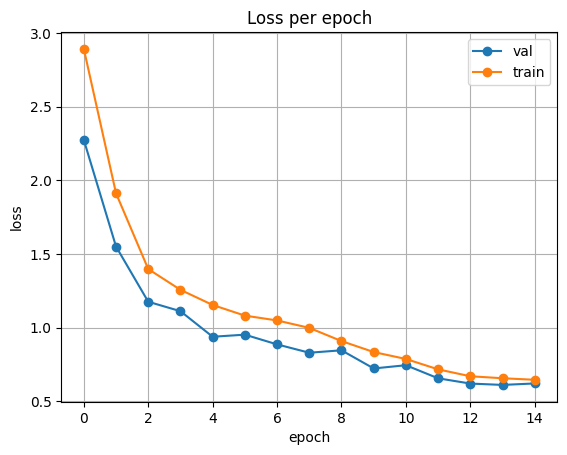

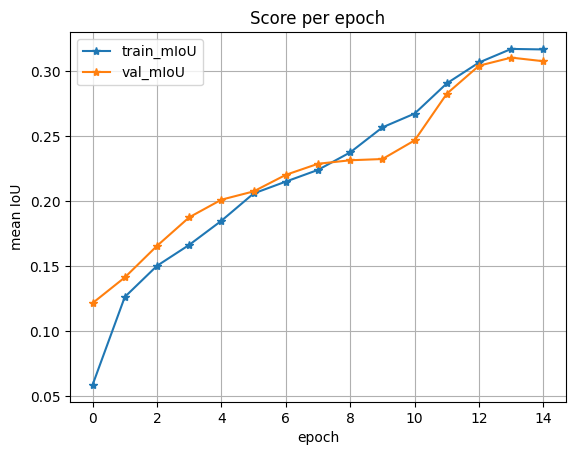

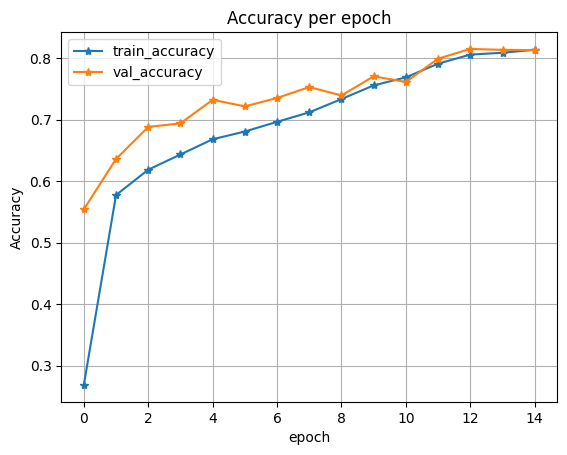

In [ ]:
plot_loss(history_mobile)
plot_score(history_mobile)
plot_acc(history_mobile)

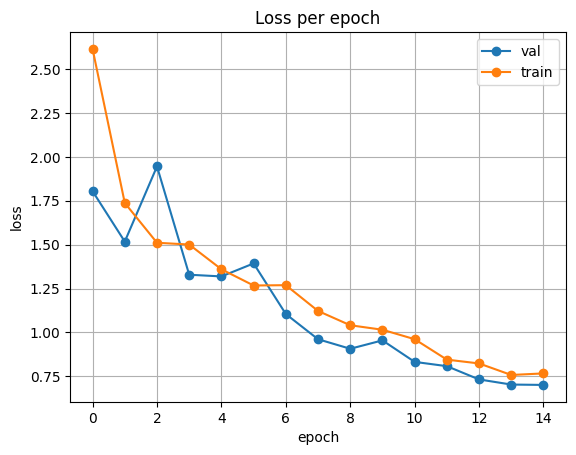

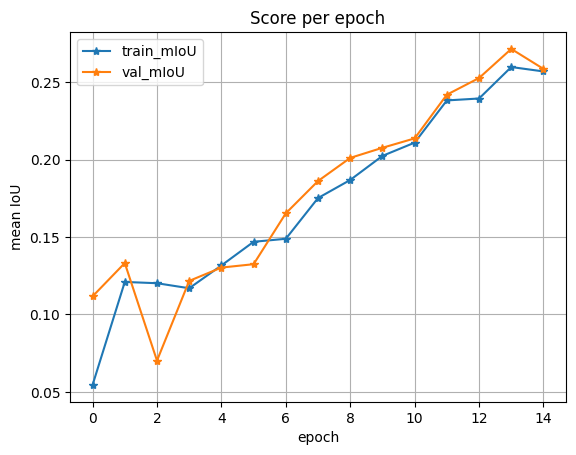

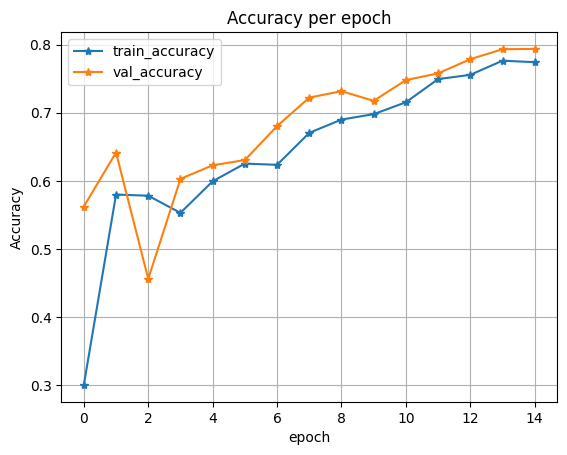

In [ ]:
plot_loss(history_resnet)
plot_score(history_resnet)
plot_acc(history_resnet)

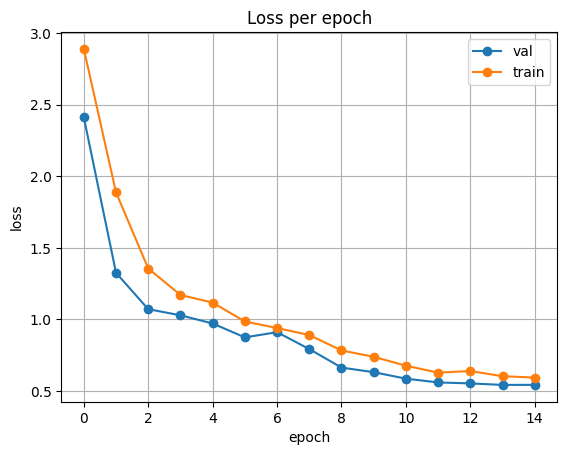

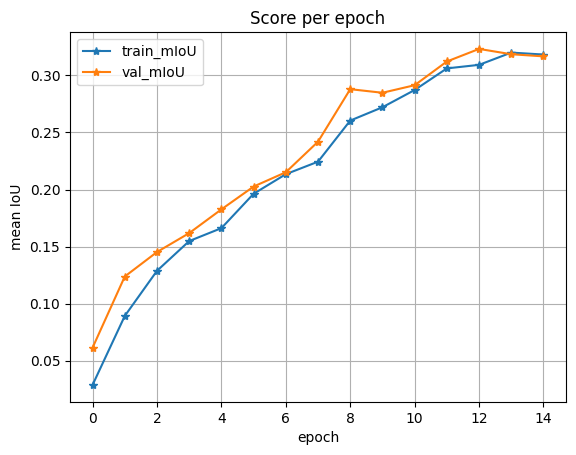

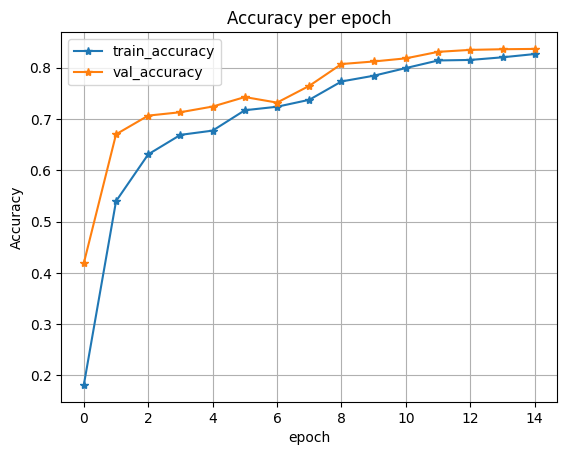

In [ ]:
plot_loss(history_efficient)
plot_score(history_efficient)
plot_acc(history_efficient)

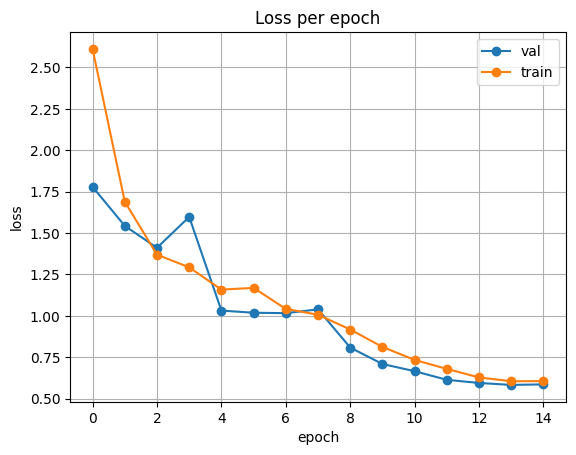

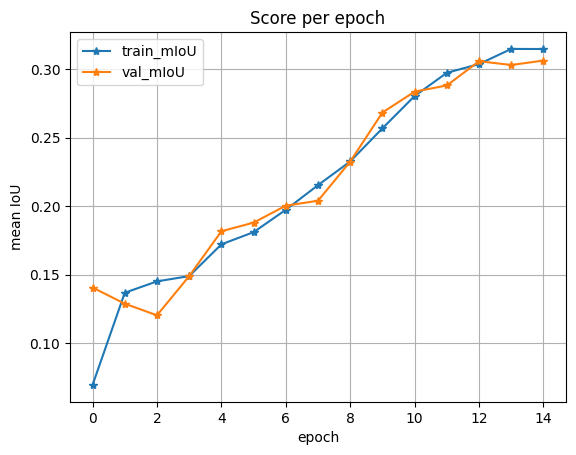

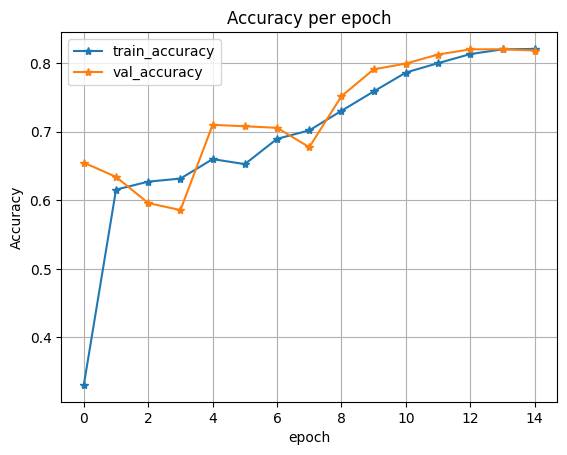

In [ ]:
plot_loss(history_densenet)
plot_score(history_densenet)
plot_acc(history_densenet)

In [ ]:
import pickle

In [ ]:
file_name = 'unet_mobilnet_hist.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(history_mobile, file)

file_name = 'unet_resnet_hist.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(history_resnet, file)

file_name = 'unet_efficient_hist.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(history_efficient, file)

file_name = 'unet_densenet_hist.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(history_densenet, file)


# Evaluation

In [54]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

## Result

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [23]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [53]:
image, mask = test_set[3]

NameError: ignored

In [ ]:
pred_mask_mob, score_mob = predict_image_mask_miou(unet_mobile, image, mask)
pred_mask_res, score_res = predict_image_mask_miou(unet_resnet, image, mask)
pred_mask_eff, score_eff = predict_image_mask_miou(unet_efficient, image, mask)
pred_mask_dense, score_dense = predict_image_mask_miou(unet_densenet, image, mask)

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(unet_mobile, test_set)
res_miou = miou_score(unet_resnet, test_set)
eff_miou = miou_score(unet_efficient, test_set)
dense_miou = miou_score(unet_densenet, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(unet_mobile, test_set)
res_acc = pixel_acc(unet_resnet, test_set)
eff_acc = pixel_acc(unet_efficient, test_set)
dense_acc = pixel_acc(unet_densenet, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

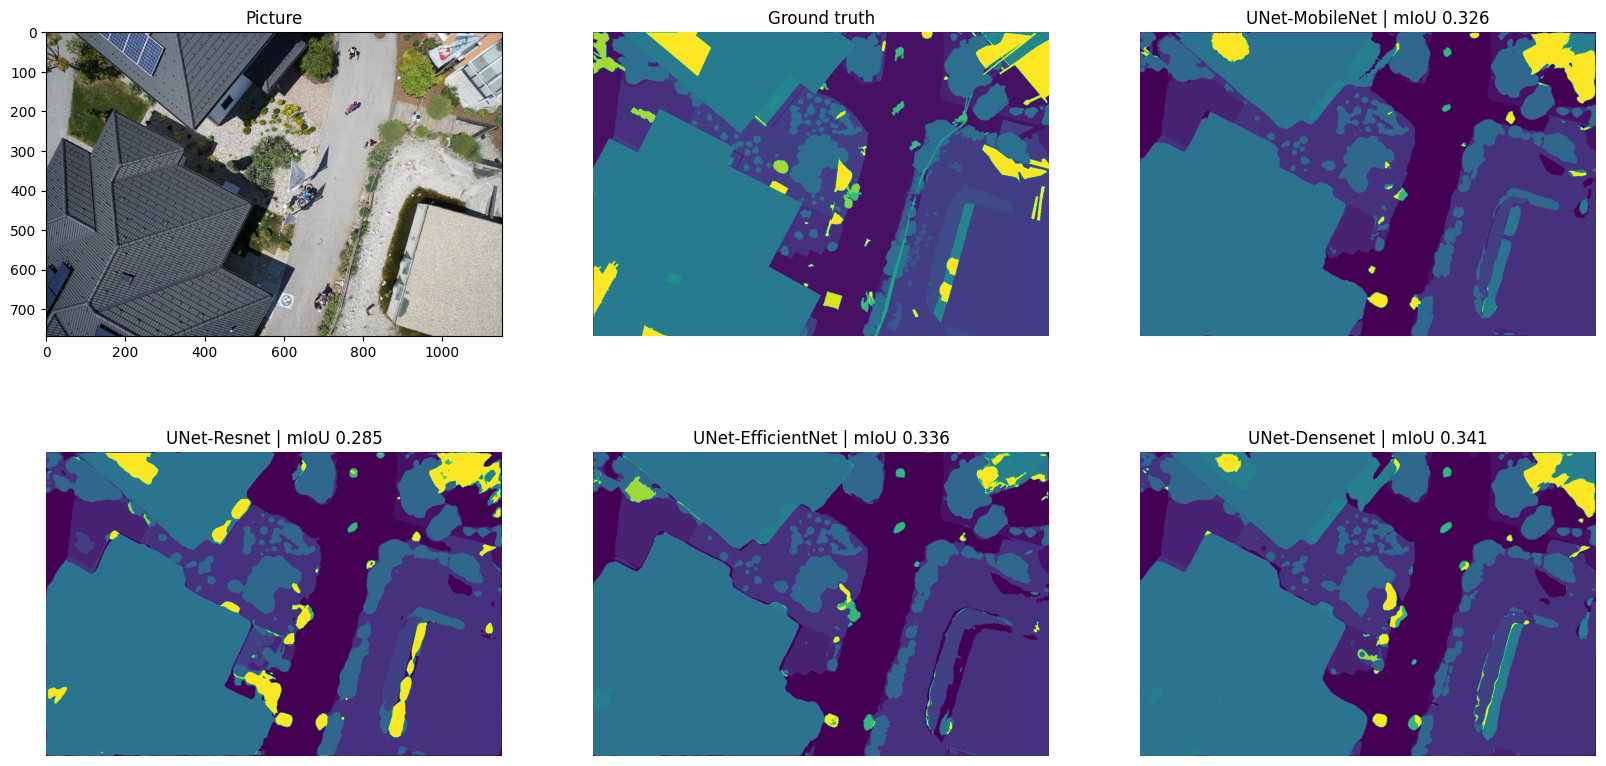

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
ax[0][0].imshow(image)
ax[0][0].set_title('Picture');

ax[0][1].imshow(mask)
ax[0][1].set_title('Ground truth')
ax[0][1].set_axis_off()

ax[0][2].imshow(pred_mask_mob)
ax[0][2].set_title('UNet-MobileNet | mIoU {:.3f}'.format(score_mob))
ax[0][2].set_axis_off()

ax[1][0].imshow(pred_mask_res)
ax[1][0].set_title('UNet-Resnet | mIoU {:.3f}'.format(score_res))
ax[1][0].set_axis_off()

ax[1][1].imshow(pred_mask_eff)
ax[1][1].set_title('UNet-EfficientNet | mIoU {:.3f}'.format(score_eff))
ax[1][1].set_axis_off()

ax[1][2].imshow(pred_mask_dense)
ax[1][2].set_title('UNet-Densenet | mIoU {:.3f}'.format(score_dense))
ax[1][2].set_axis_off()

In [74]:
model_loaded = torch.load('fpn-densenet.pt')
model_loaded.eval()

FPN(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding(

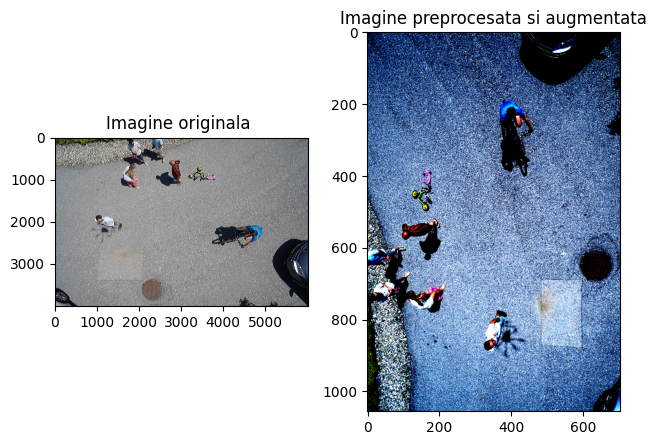

In [142]:
image, mask, originala = train_set[59]
#pred_mask_mob_q, score_mob_q = predict_image_mask_pixel(model_loaded, image, mask)

plt.subplot(122)
plt.title('Imagine preprocesata si augmentata')
qq = np.array(image.permute(2, 1, 0)).astype('uint8')
plt.imshow(image.permute(2,1,0))
plt.subplot(121)
plt.imshow(np.fliplr(originala))
plt.title('Imagine originala ')
plt.tight_layout()

In [127]:
image.shape

torch.Size([3, 704, 1056])

In [133]:
np.min(image)

TypeError: ignored

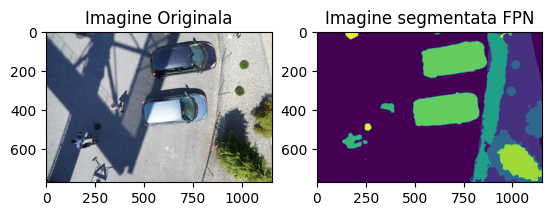

<Figure size 640x480 with 0 Axes>

In [80]:
pred_mask_mob_q, score_mob_q = predict_image_mask_pixel(model_loaded, image, mask)
plt.subplot(121)
plt.title('Imagine Originala')
plt.imshow(image)
plt.subplot(122)
plt.imshow(pred_mask_mob_q)
plt.title('Imagine segmentata FPN')
plt.show()
plt.tight_layout()